In [3]:
import pathlib
import pickle

from astropy.io import fits
import astropy.table as at
from astropy.constants import G
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from gala.units import galactic
from scipy.stats import binned_statistic, binned_statistic_2d
import torusimaging as oti
from torusimaging_helpers.make_sim_data import make_mgfe
from torusimaging_helpers.plot import (
    plot_bdata,
    plot_data_model_residual,
    plot_spline_functions,
)

import jax

jax.config.update("jax_enable_x64", True)

In [4]:
# See: scripts/jason-sims/aligner.py
# tbl = at.Table(fits.getdata("../data/Jason-r2-B2-disk.fits"))
tbl = fits.getdata("../data/Jason-r2-B2-disk.fits", memmap=True)

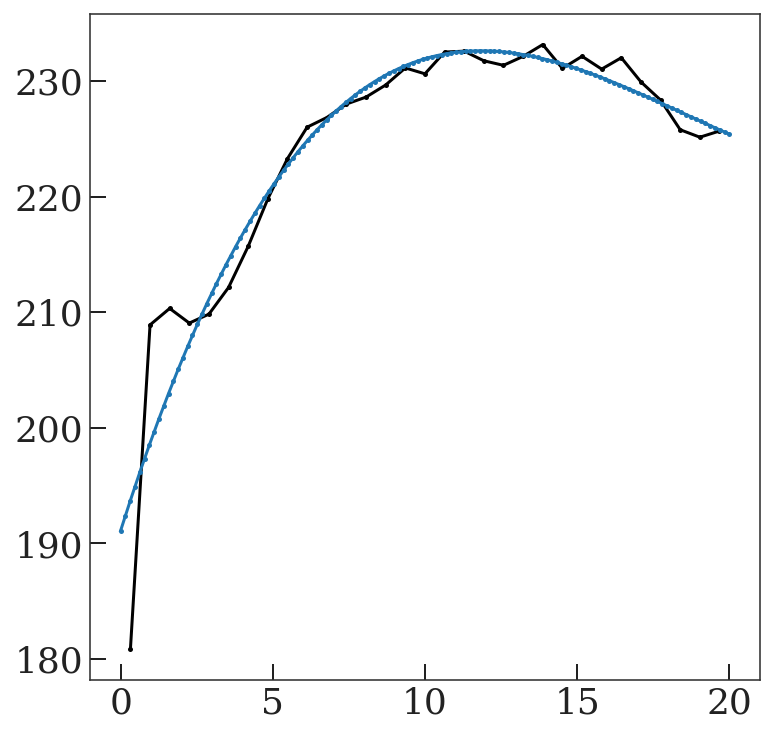

In [5]:
# Select low vertical and radial action particles to get rotation curve:
J_mask = (tbl["J"][:, 0] < np.nanpercentile(tbl["J"][:, 0], 15)) & (
    tbl["J"][:, 2] < np.nanpercentile(tbl["J"][:, 2], 15)
)
vc_stat = binned_statistic(
    tbl["R"][J_mask], tbl["v_phi"][J_mask], bins=np.linspace(0, 20, 32)
)
xc = 0.5 * (vc_stat.bin_edges[:-1] + vc_stat.bin_edges[1:])
vc_poly = np.polynomial.Polynomial.fit(xc, vc_stat.statistic, deg=3)

vc = vc_poly(tbl["R"])
Rg = tbl["J"][:, 1] / vc

plt.plot(xc, vc_stat.statistic)

_grid = np.linspace(0, 20, 128)
plt.plot(_grid, vc_poly(_grid))

In [6]:
xy_stat = binned_statistic_2d(
    tbl["xyz"][:, 0],
    tbl["xyz"][:, 1],
    tbl["vxyz"][:, 2],
    bins=np.linspace(-20, 20, 128),
)

8.0


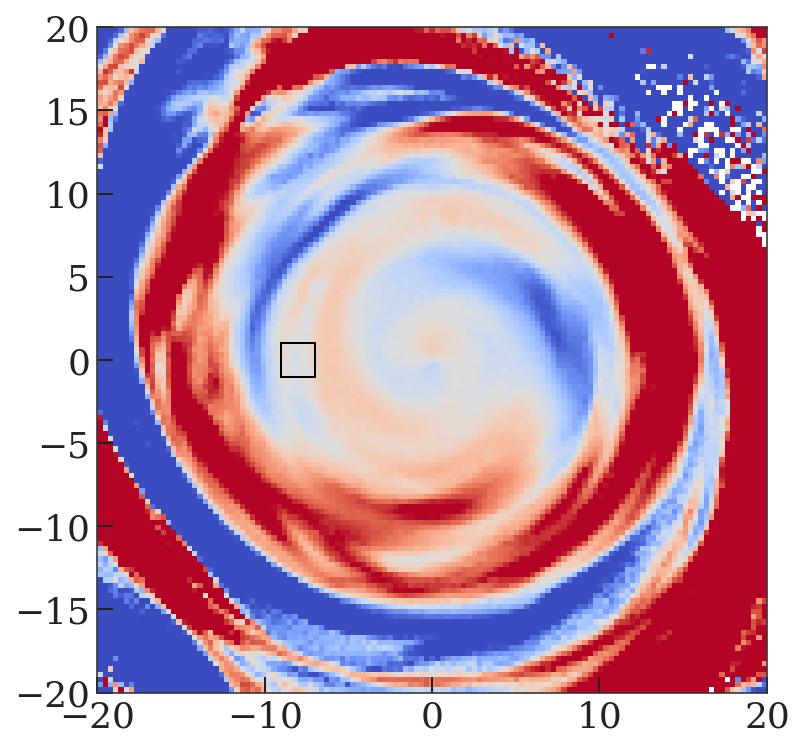

In [237]:
# x0 = -6.5
# y0 = 5
x0 = -8.0
y0 = 0
R0 = np.sqrt(x0**2 + y0**2)
print(R0)

xy_size = 2.0

fig, ax = plt.subplots(figsize=(6, 6))
ax.pcolormesh(
    xy_stat.x_edge,
    xy_stat.y_edge,
    xy_stat.statistic.T,
    cmap="coolwarm",
    vmin=-10,
    vmax=10,
)
rect = mpl.patches.Rectangle(
    (x0 - xy_size / 2, y0 - xy_size / 2),
    xy_size,
    xy_size,
    facecolor="none",
    edgecolor="k",
)
ax.add_patch(rect)

In [238]:
print(vc_poly(R0), R0)  # 228.36 * 7.5 ~= 1712

229.35446153457391 8.0


In [316]:
mask = (
    (np.abs(tbl["R"] - Rg) < xy_size / 2)
    & (np.abs(tbl["v_R"]) < 15)
    & (np.abs(tbl["xyz"][:, 0] - x0) < xy_size / 2)
    & (np.abs(tbl["xyz"][:, 1] - y0) < xy_size / 2)
)
pdata = at.QTable(tbl[mask])

In [317]:
with u.set_enabled_equivalencies(u.dimensionless_angles()):
    zmax = np.sqrt(2 * pdata["init_J"][:, 2] / pdata["init_Omega"][:, 2]) * u.kpc

rng = np.random.default_rng(123)
pdata["z"] = pdata["xyz"][:, 2] * u.kpc
pdata["v_z"] = pdata["vxyz"][:, 2] * u.km / u.s
# pdata["mgfe"], pdata["mgfe_err"] = make_mgfe(zmax, rng=rng, slope=0.12, std=0.025)
pdata["mgfe"], pdata["mgfe_err"] = make_mgfe(zmax, rng=rng, std=0.05 / 4)

In [318]:
# max_z = np.round(2 * np.nanpercentile(pdata["z"].to(u.kpc), 99), 1)
# max_vz = np.round(2 * np.nanpercentile(pdata["v_z"].to(u.km / u.s), 99), 0)
max_z = 1.8 * u.kpc
max_vz = 72 * u.km / u.s

print(max_z, max_vz)
zvz_bins = {
    "pos": np.linspace(-max_z, max_z, 151),
    "vel": np.linspace(-max_vz, max_vz, 151),
}

1.8 kpc 72.0 km / s


In [319]:
bdata = oti.get_binned_label(
    pdata["z"].astype("f8"),
    pdata["v_z"].astype("f8"),
    label=pdata["mgfe"].astype("f8"),
    label_err=pdata["mgfe_err"].astype("f8"),
    bins=zvz_bins,
    units=galactic,
)

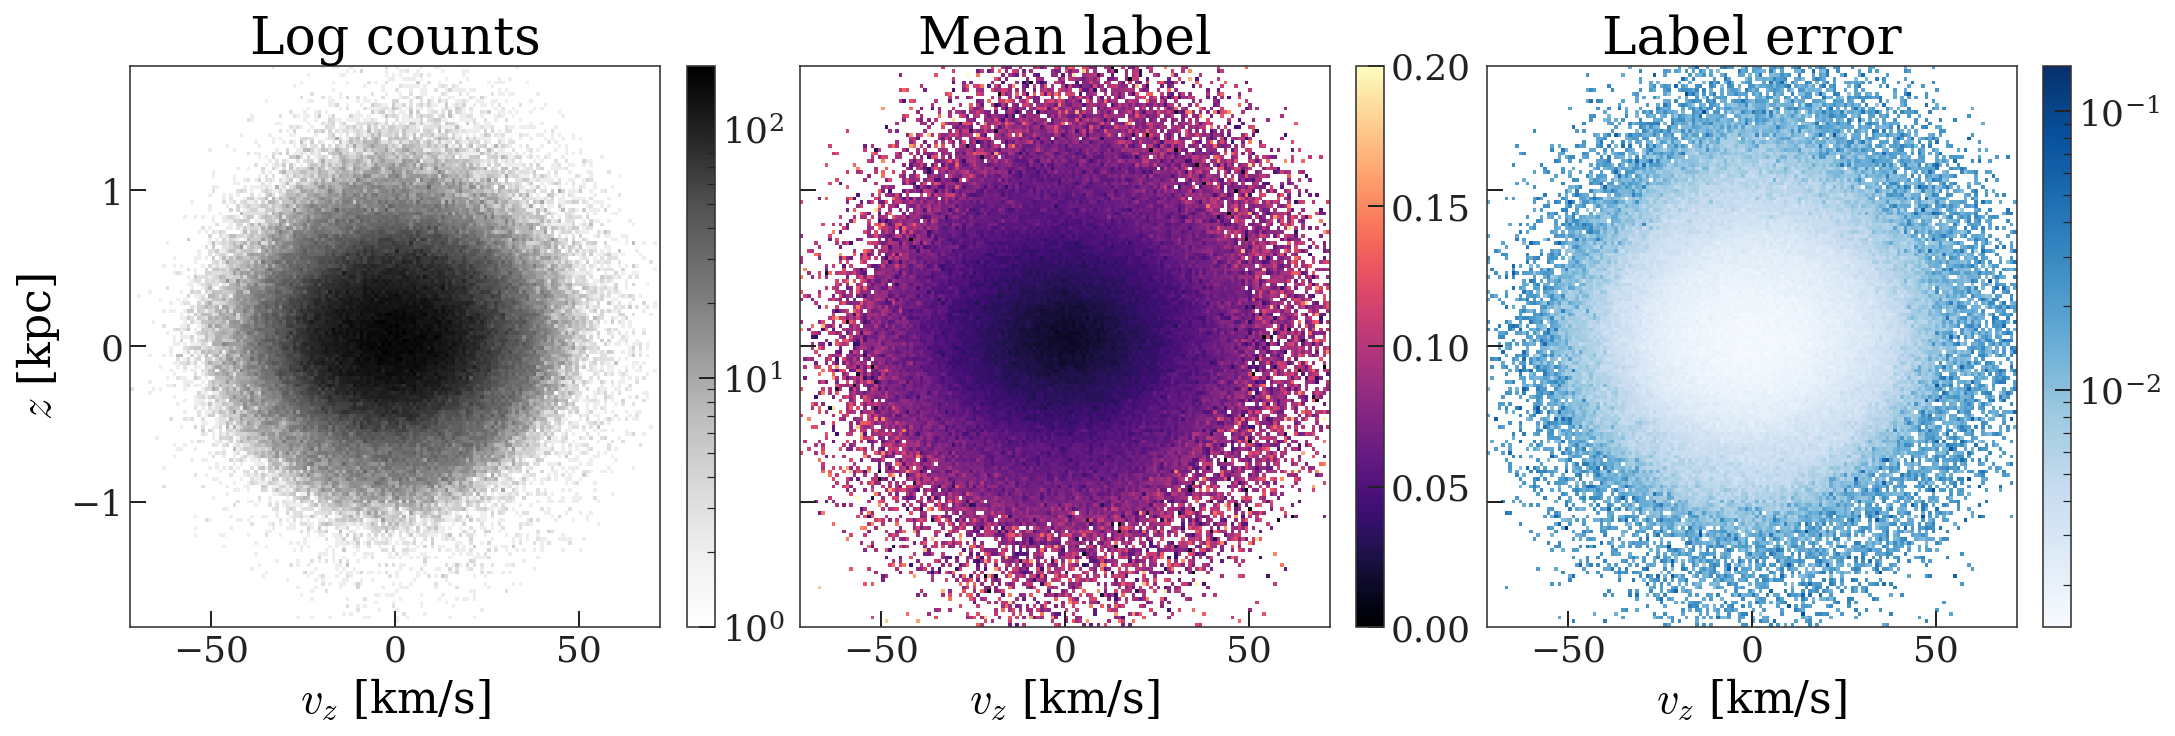

In [320]:
_ = plot_bdata(bdata, label_vlim=(0, 0.2))

In [321]:
# model, bounds, init_params = oti.TorusImaging1DSpline.auto_init(
#     bdata,
#     label_knots=10,
#     e_knots={2: 16, 4: 4},
#     label_l2_sigma=1.0,
#     label_smooth_sigma=0.5,
#     e_l2_sigmas={2: 0.1, 4: 0.1},
#     e_smooth_sigmas={2: 0.2, 4: 0.2},
#     label_knots_spacing_power=0.75,
#     e_knots_spacing_power=0.75,
# )

# init_params["e_params"][2]["vals"] = np.full_like(
#     init_params["e_params"][2]["vals"], -0.5
# )
# init_params["e_params"][4]["vals"] = np.full_like(
#     init_params["e_params"][4]["vals"], np.log(0.05 / model._label_knots.max())
# )

# import jax.numpy as jnp

# def regularization_func_test(model, params):
#     p = 0.0
#     for m, func in model.e_funcs.items():
#         z_knots = model._e_knots[m][1:] / jnp.sqrt(jnp.exp(params["ln_Omega0"]))
#         daz = model._get_dacc_dpos_vmap(z_knots, params) / 1e-4
#         p += jnp.sum(1e2 * jnp.log(1 + jnp.exp(daz)))
#     return p

# model, bounds, init_params = oti.TorusImaging1DSpline.auto_init(
#     bdata,
#     label_knots=8,
#     e_knots={2: 8, 4: 4},
#     # regularization_func=regularization_func_test,
#     dacc_strength=1e2,
#     label_knots_spacing_power=0.75,
#     e_knots_spacing_power=0.5,
# )

model, bounds, init_params = oti.TorusImaging1DSpline.auto_init(
    bdata,
    label_knots=8,
    e_knots={2: 8, 4: 4},
    label_l2_sigma=1.0,
    label_smooth_sigma=0.5,
    e_l2_sigmas={2: 1.0, 4: 1.0},
    e_smooth_sigmas={2: 0.2, 4: 0.2},
    dacc_strength=1e3,
    label_knots_spacing_power=0.75,
    e_knots_spacing_power=0.5,
)

init_params["e_params"][2]["vals"] = np.full_like(
    init_params["e_params"][2]["vals"], -0.1
)
init_params["e_params"][4]["vals"] = np.full_like(
    init_params["e_params"][4]["vals"], np.log(0.05 / model._label_knots.max())
)

In [322]:
data_kw = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
data_kw = {k: v[mask] for k, v in data_kw.items()}

test_val = model.objective_gaussian(init_params, **data_kw)
print(f"Test evaluation of objective function: {test_val}")

Test evaluation of objective function: 6.80325280616625


In [323]:
print("Running optimize...")
res = model.optimize(
    init_params,
    objective="gaussian",
    jaxopt_kwargs=dict(tol=1e-8),
    bounds=bounds,
    **data_kw
)
res.state.success, res.state.iter_num, res.state.fun_val

Running optimize...


(True, 1541, Array(0.89371928, dtype=float64, weak_type=True))

In [324]:
init_params["e_params"][2]

{'vals': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1])}

In [325]:
res.params["e_params"][2]

{'vals': Array([-0.14283955, -0.19249722, -0.37193205, -0.69637665, -0.45216803,
        -0.90190331, -1.51038063], dtype=float64)}

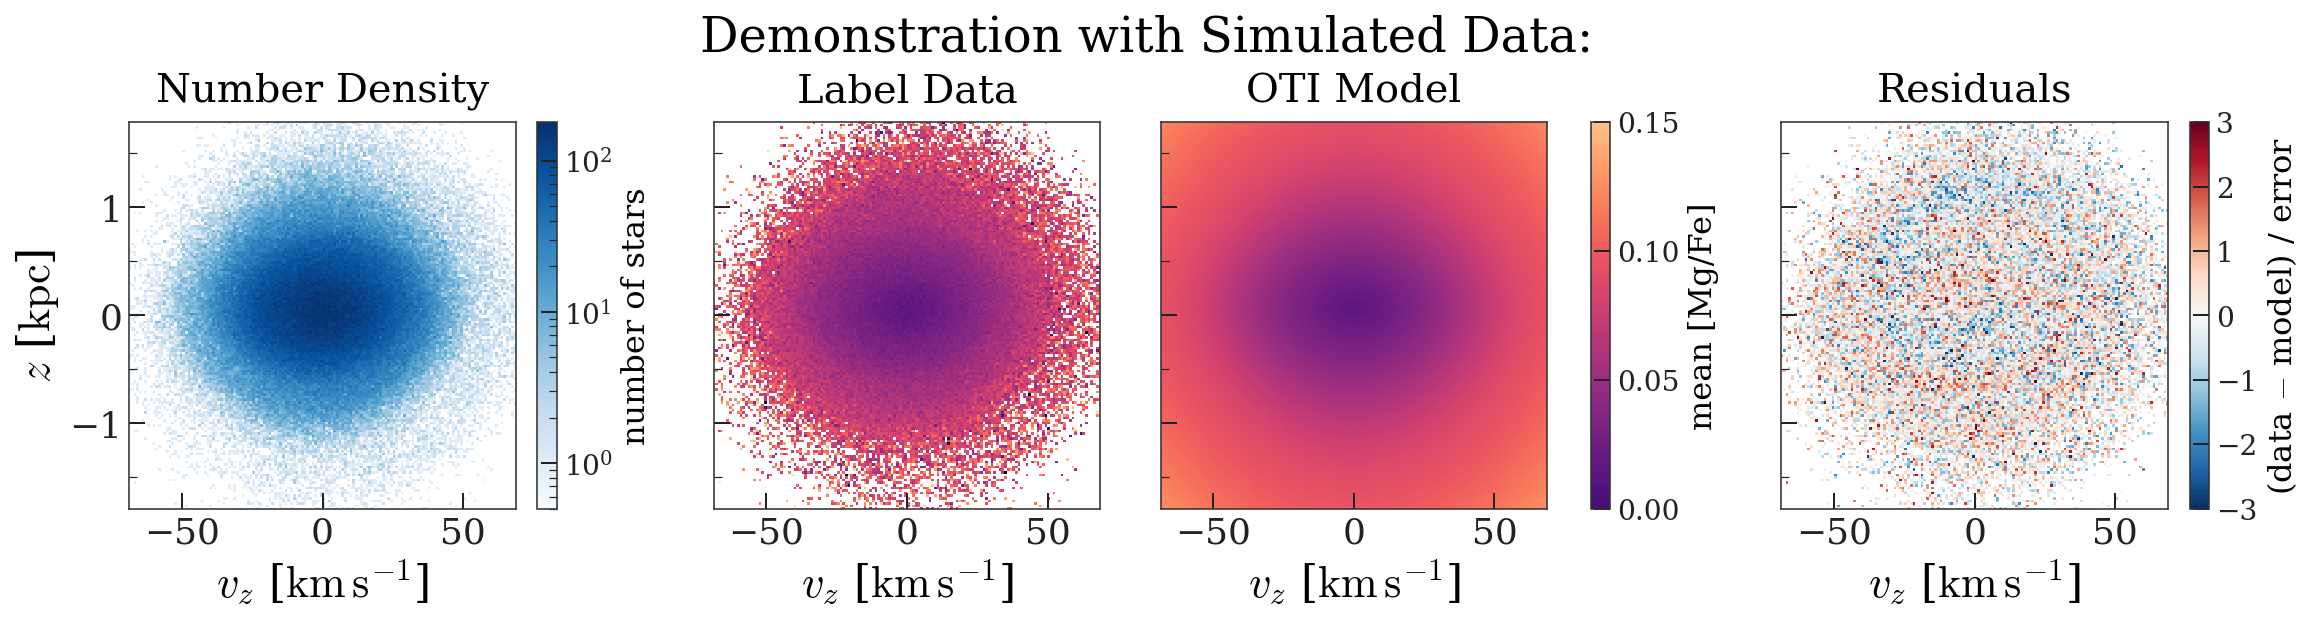

In [326]:
_ = plot_data_model_residual(model, bdata, res.params, zlim=bdata["pos"].max())

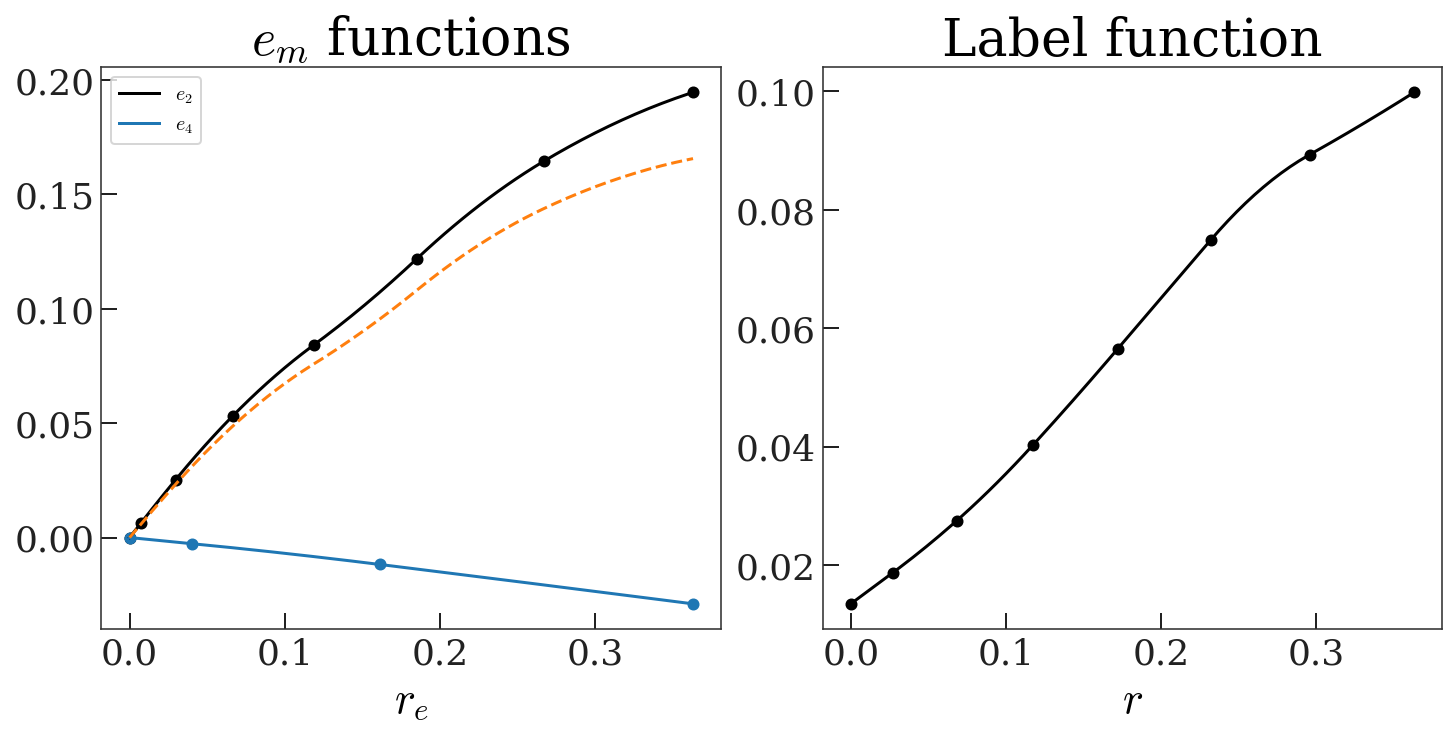

In [327]:
_ = plot_spline_functions(model, res.params)

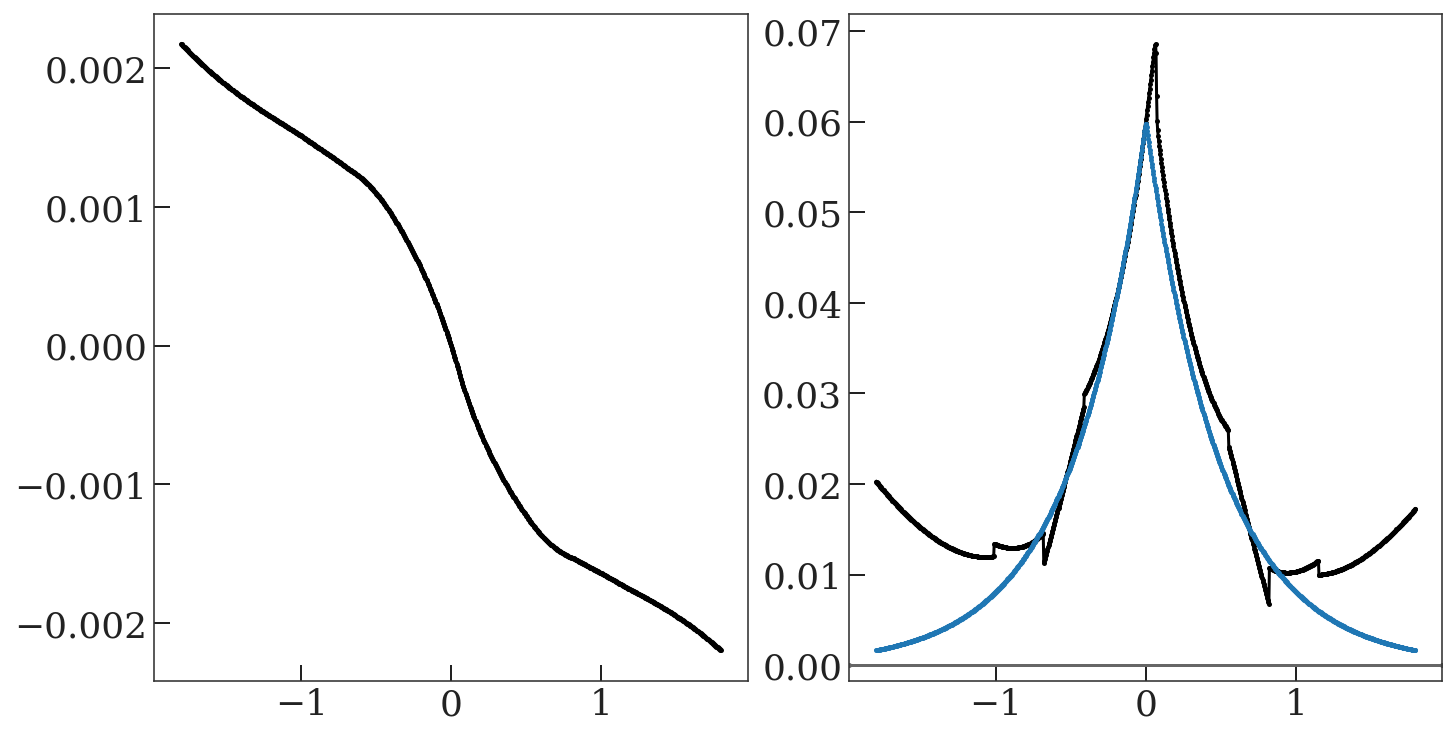

In [335]:
z_grid = np.linspace(-1, 1, 1024) * max_z
az = model.get_acceleration(z_grid, res.params)
daz_dz = model.get_acceleration_deriv(z_grid, res.params)

# az_knots = model.get_acceleration(model._e_knots[2], res.params)
# daz_dz_knots = model.get_acceleration_deriv(model._e_knots[2], res.params)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), layout="constrained", sharex=True)
axes[0].plot(z_grid.value, az.value)
axes[1].plot(
    z_grid.value, (np.abs(daz_dz) / (4 * np.pi * G)).to_value(u.Msun / u.pc**3)
)
axes[1].plot(z_grid.value, 0.06 * np.exp(-np.abs(z_grid.value) / 0.5))
axes[1].axhline(0.0)

In [336]:
zgrid = np.linspace(-1, 1, 128) * max_z

In [337]:
a_unit = u.km / u.s / u.Myr
bestfit_acc = model.get_acceleration(zgrid, res.params).to(a_unit)

In [338]:
with open("/mnt/home/jhunt/ceph/Bonsai/r2/B2/AdrianAccel702.p", "rb") as f:
    rrt, zzt, ppt, accelt = pickle.load(f)

In [339]:
grid_r_mask = (rrt == R0) & np.isclose(ppt, ppt[np.argmin(np.abs(ppt - np.pi))])

In [340]:
from scipy.interpolate import InterpolatedUnivariateSpline

shit = InterpolatedUnivariateSpline(zzt[grid_r_mask], accelt[grid_r_mask, 2])
fuck = InterpolatedUnivariateSpline(zgrid.value, bestfit_acc.to_value(a_unit))
eval_r = 0.25
norm = np.mean([shit(eval_r) / fuck(eval_r), shit(-eval_r) / fuck(-eval_r)])
print(norm)

# norm = (1*u.cm/u.s**2).to_value(u.km/u.s/u.Myr)
true_zz_grid = zzt[grid_r_mask]
true_acc_grid = accelt[grid_r_mask, 2] / norm

true_acc_interp = InterpolatedUnivariateSpline(true_zz_grid, true_acc_grid)
true_acc = true_acc_interp(zgrid.value)

206548664.06581366


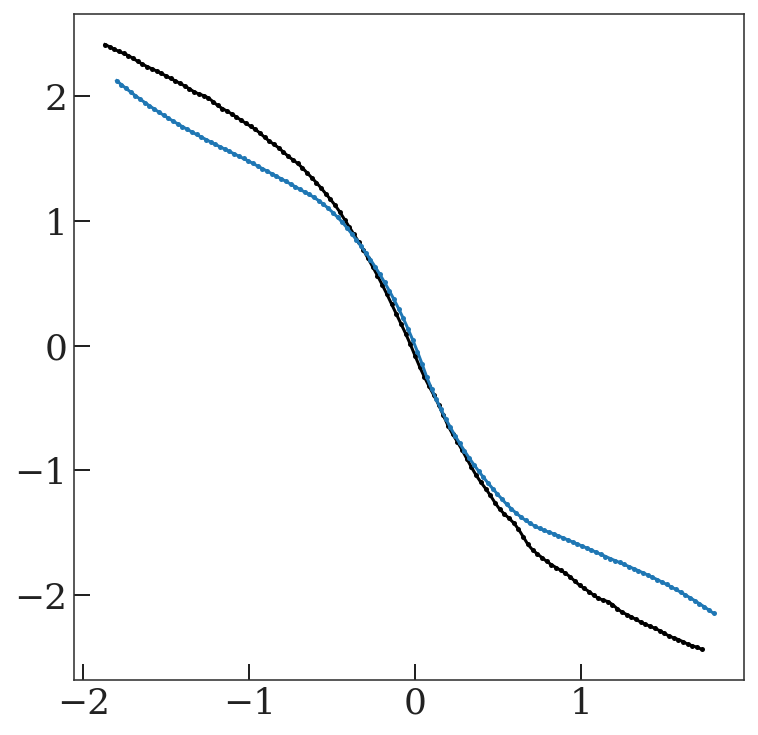

In [341]:
plt.plot(zgrid.value - res.params["pos0"], true_acc)
plt.plot(zgrid.value, bestfit_acc.to_value(a_unit))